# Feature Selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

การมีจำนวน feature (<b>dimensionality</b>) มากไม่ใช่ว่าจะดี

<img src="../images/performance_vs_dim.png" width="400" /><br />

อีกทั้งถ้ามีจำนวน feature มากขึ้น เราต้องมีข้อมูลมากขึ้นด้วยถึงจะเพียงพอในการ training

<img src="../images/data_amount_vs_dim.png" width="500" /><br />

Feature selection คือการเอา feature ที่ไม่มีประโยชน์หรือมีความสำคัญน้อยออก เพื่อให้ model มี performance ที่ดีขึ้น สามารถทำได้ดังนี้ (ไม่จำเป็นต้องทำทั้งหมด)
- <b>Feature correlation</b>
- <b>Feature permutation</b>
- เอาหลาย feature มาดำเนินการบางอย่างด้วยกัน กลายเป็น feature เดียว
- เอา feature ที่ constant ออก
- สำหรับ regression เราสามารถเอา feature ที่มี weight ต่ำออกได้

การเลือกเฉพาะ feature ที่สำคัญที่สุดมาใช้ ทำให้
- model สามารถถูกตีความได้ง่ายขึ้น
- ถูก trained เร็วขึ้น
- ใช้ข้อมูลน้อยลง
- implement และ maintain ง่ายขึ้น
- มี validation score ที่ converge เร็วกว่า

อย่างไรก็ตาม ถ้าเอา feature ออกมาเกินไป อาจทำให้มี dimensionality น้อยเกินไป และทำให้ model performance ไม่ถูก optimised

## Feature correlation

หา feature แต่ละคู่ที่ highly correlate กัน แล้วเก็บ feature แค่อันเดียวเอาไว้

In [2]:
# Data pre-processing

# Import data and drop duplicates
data = pd.read_csv('../data/wines_binary.csv').drop_duplicates()
# Separate features (X) and target (y)
X, y = data.drop(columns='is_good_quality'), data['is_good_quality']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42)
# Scale features
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [3]:
# Investigate feature corrlation (also include the target)
corr = data.corr()
corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,sulphates,alcohol,is_good_quality
fixed acidity,1.000000,0.617116,0.182739,0.146111,-0.014402,-0.000911,-0.003668,-0.000007,-0.003420,0.112230,-0.374721
volatile acidity,0.617116,1.000000,0.782848,0.290229,0.595967,-0.004785,-0.001347,0.000326,-0.006043,0.642525,-0.685634
citric acid,0.182739,0.782848,1.000000,0.340390,0.569245,-0.002325,0.001992,-0.001013,-0.003210,0.331512,-0.649905
residual sugar,0.146111,0.290229,0.340390,1.000000,-0.360880,0.001079,0.007045,-0.002504,-0.004335,0.029340,-0.344219
chlorides,-0.014402,0.595967,0.569245,-0.360880,1.000000,-0.006610,-0.001555,0.000633,-0.001720,0.724732,-0.349374
free sulfur dioxide,-0.000911,-0.004785,-0.002325,0.001079,-0.006610,1.000000,-0.000498,0.005199,-0.000371,-0.007826,0.005721
total sulfur dioxide,-0.003668,-0.001347,0.001992,0.007045,-0.001555,-0.000498,1.000000,0.005508,0.001655,-0.000812,-0.002813
density,-0.000007,0.000326,-0.001013,-0.002504,0.000633,0.005199,0.005508,1.000000,-0.001584,0.001405,0.002872
sulphates,-0.003420,-0.006043,-0.003210,-0.004335,-0.001720,-0.000371,0.001655,-0.001584,1.000000,-0.006114,0.006198
alcohol,0.112230,0.642525,0.331512,0.029340,0.724732,-0.007826,-0.000812,0.001405,-0.006114,1.000000,-0.350558


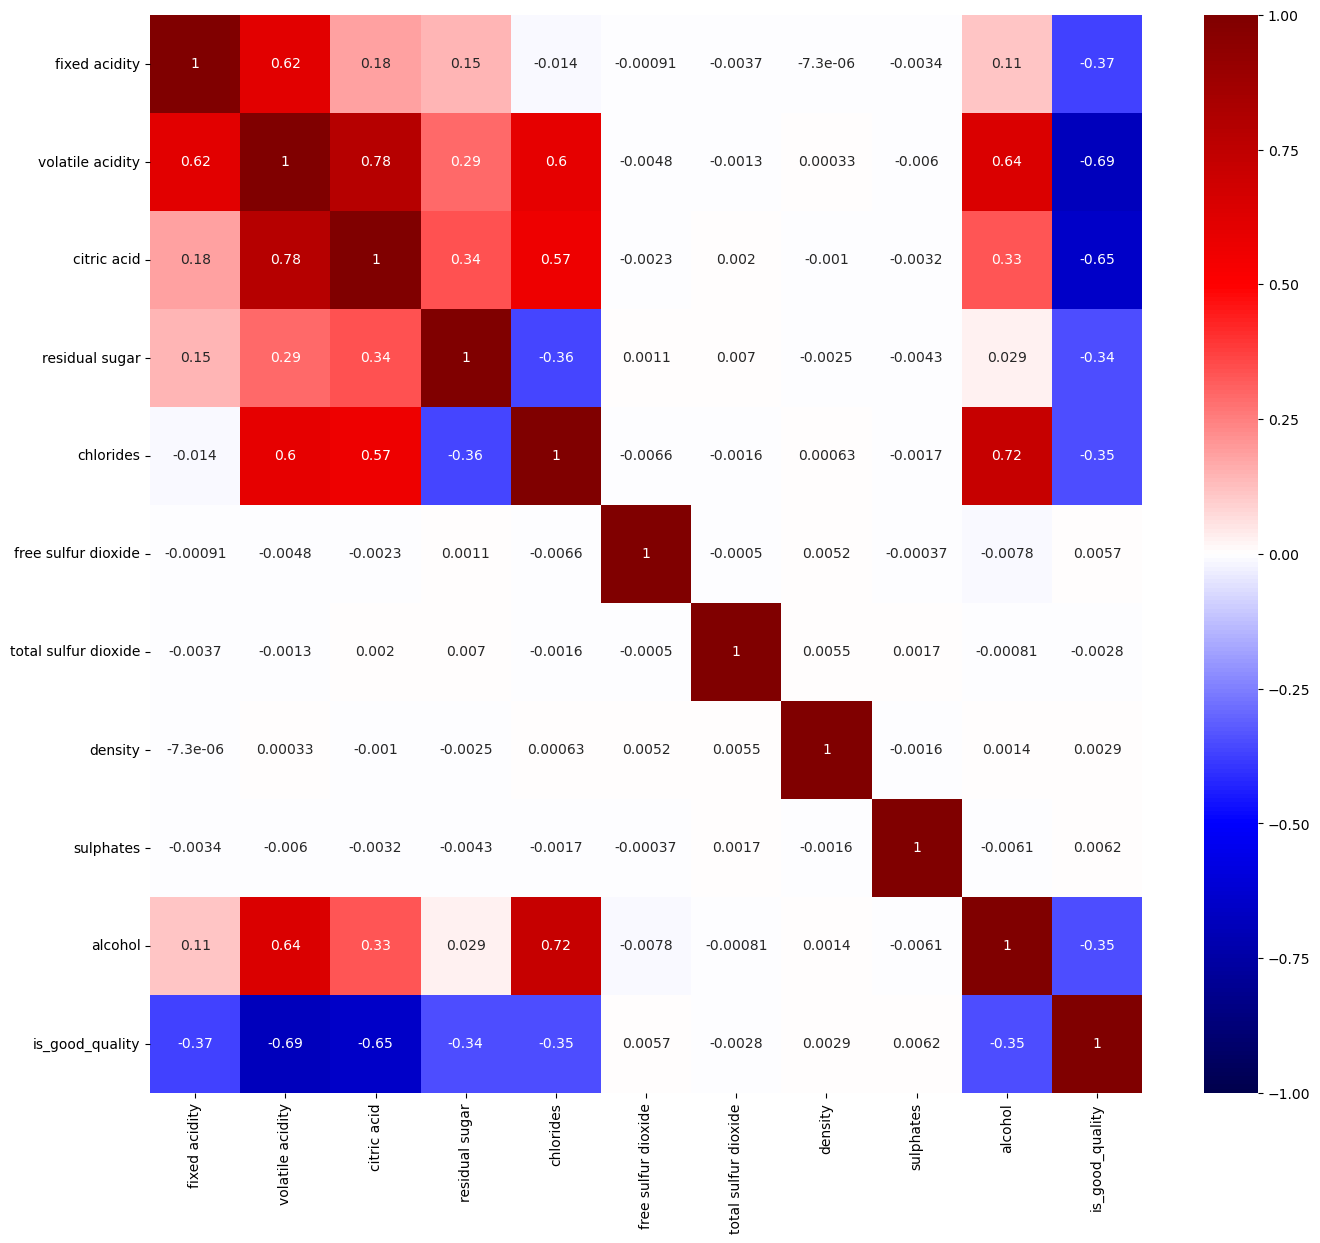

In [4]:
# Plot correlation heatmap
fig, ax = plt.subplots(1,1, figsize=(16,14))
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            vmin=-1,
            vmax=1,
            cmap="seismic",
            ax=ax,
            annot=corr);

## Feature permutation

เอา feature หนึ่งออก และใช้ feature ที่เหลือในการเทรน base model จากนั้นนำ model ไปใช้กับ test set และวัด test score ถ้า test score ลดลงมากเมื่อเทียบกับ test score ของ model ที่ถูกเทรนโดยใช้ทุก feature แสดงว่า feature ที่เอาออกนั้นสำคัญ ต้องเก็บเอาไว้

ใช้ `sklearn.inspection.permutation_importance`

In [5]:
# Use a logistic regressor as a base model
base_model = LogisticRegression(max_iter=3000).fit(X_train, y_train)
# Perform permutation
permutation_score = permutation_importance(base_model, X_train, y_train, n_repeats=10)
# Unstack results
importance_df = pd.DataFrame(
    np.vstack((X_train.columns, permutation_score.importances_mean)).T
)
importance_df.columns = ['Feature','Score decrease']
# Order by importance
importance_df.sort_values(by="Score decrease", ascending=False)

,Feature,Score decrease
2,citric acid,0.227349
0,fixed acidity,0.064441
9,alcohol,0.012701
1,volatile acidity,0.006849
3,residual sugar,0.003247
4,chlorides,0.000621
6,total sulfur dioxide,0.000024
7,density,-0.000014
5,free sulfur dioxide,-0.000046
8,sulphates,-0.000066


In [6]:
# The most important features
important_features = ["citric acid", "fixed acidity", "alcohol"]

In [7]:
# Compute the mean score of the base model if all features are used in training
scores = cross_val_score(base_model, X_train, y_train, cv=3)
scores.mean()

0.8602000127998988

In [8]:
# Compute the mean score of the base model if only important features are used in training
# We can see that the mean score nearly remains unchanged
scores = cross_val_score(base_model, X_train[important_features], y_train, cv=3)
scores.mean()

0.8591428579016801

In [9]:
# Define a function for plotting learning curves
def plot_learning_curve(model, X_train, X_val, y_train, y_val):
    train_scores, val_scores, num_training_samples = [], [], []
    # Loop to increase every 10 training samples
    for i in range(1, 200):
        # Prepare training samples
        X_10i = X_train[:i*10]
        y_10i = y_train[:i*10]
        num_training_samples.append(i*10)
        # Predict on training samples and validation set by a KNN regressor
        lr = model.fit(X_10i, y_10i)
        y_train_pred = lr.predict(X_10i)
        y_val_pred = lr.predict(X_val)
        # Store training and validation RMSEs
        train_scores.append(accuracy_score(y_10i, y_train_pred))
        val_scores.append(accuracy_score(y_val, y_val_pred))

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(num_training_samples, train_scores, label="Training accuracy")
    ax.plot(num_training_samples, val_scores, label="Validation accuracy")
    ax.set(xlabel="The number of training samples", ylabel="accuracy", title=f"The learning curve of {model}")
    ax.legend()

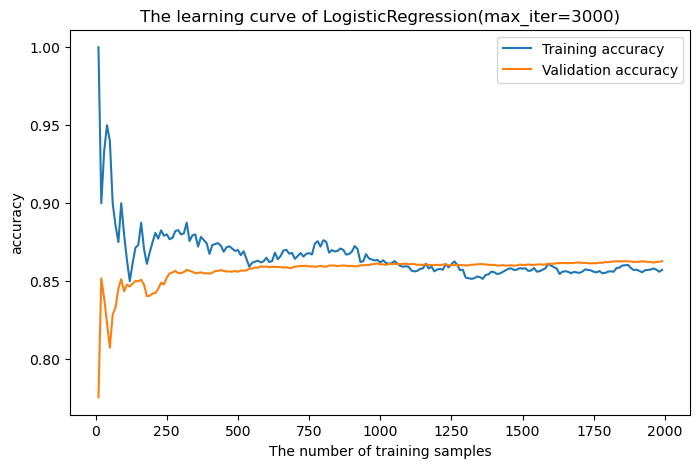

In [10]:
# Create the learning curves of the base model if all features are used in training
plot_learning_curve(base_model, X_train, X_test, y_train, y_test)

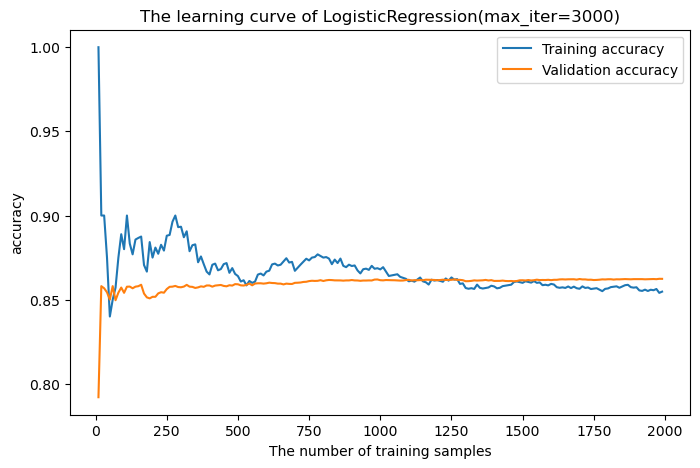

In [11]:
# Create the learning curves of the base model if only important features are used in training
# We can see that the validation curve of this model converges faster
plot_learning_curve(base_model, X_train[important_features], X_test[important_features], y_train, y_test)